In [73]:
#Импорты библиотек
import pandas as pd
import numpy as np

#from StandartScaler import OnlineStandartScaler

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

import warnings 
warnings.filterwarnings("ignore")

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import LSTM, GRU, Dense,Input, Dropout, TimeDistributed

import xgboost
#import catboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from sklearn import preprocessing

In [2]:
#Инициализируем эксперимент для comet.ml
#experiment = Experiment(
  #api_key="7OG1voSLXiuymKjZfEDg00rMB",
  #project_name="motorica-first-sprint",
  #workspace="gdudyrev"
#)

## Задача
Необходимо обучить модель, которая сможет предсказывать жесты пилота с помощью показаний с оптомографических датчиков.

In [74]:
random_seed = 42

## Формирование данных

Нам необходимо сформировать датасет, с которым мы будем работать.

Реализуем функцию для считывания наших данных.

In [75]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

Считываем данные.

In [76]:
path_data = './data/2023-05-15_16-16-08.palm'
data = read_omg_csv(path_data,
                    n_omg_channels=50,
                    n_acc_channels=3, 
                    n_gyr_channels=3, 
                    n_enc_channels=6, 
                    n_mag_channels=0)
print(f'Data shape: {data.shape}')
data.head()

Data shape: (29145, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,2,4,3,843,1831,1,1387,2,4,1,...,0,0,0,0,0,0,0,0,0,523008
1,5,5,4,840,1834,0,1391,3,0,4,...,0,0,0,0,0,0,0,0,0,523041
2,6,3,4,838,1830,3,1388,4,1,4,...,0,0,0,0,0,0,0,0,0,523074
3,0,2,3,832,1826,1,1383,4,0,4,...,0,0,0,0,0,0,0,0,0,523107
4,6,3,7,840,1834,2,1391,5,3,5,...,0,0,0,0,0,0,0,0,0,523140


В итоге у нас есть следующая таблица, в которой:

1. [X features]:
    * '0', ..., '49' - каналы OMG датчиков
    * 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
    * 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
2. 'BUTTON' - не используется
3. 'SYNC' - синхронизация данных с протоколом
4. 'ts' - метка времени

Удалим признаки, которые не будем использовать.

In [77]:
drop_features = ['ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'ts']
data = data.drop(drop_features, axis=1)

In [78]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,SYNC
0,2,4,3,843,1831,1,1387,2,4,1,...,25,26,3,13,1,11,18,40,30,0
1,5,5,4,840,1834,0,1391,3,0,4,...,23,20,10,11,1,10,16,38,28,0
2,6,3,4,838,1830,3,1388,4,1,4,...,24,17,10,12,1,11,17,36,28,0
3,0,2,3,832,1826,1,1383,4,0,4,...,20,24,10,14,1,9,18,35,25,0
4,6,3,7,840,1834,2,1391,5,3,5,...,22,16,9,10,0,11,14,32,27,0


Заметим, что в данных нет целевой переменной. Давайте получим ее.

In [79]:
#Для начала считываем необходимые данные
target_data = pd.read_csv(f'{path_data}.protocol.csv', index_col=0)
print(f'Target data shape: {target_data.shape}')
#Посмотрим правильно ли они считались
target_data.head(10)

Target data shape: (271, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


Мой вариант кодирования.

In [8]:
#Переменная, которая будет хранить уникальные жесты
#gestures = set()

#Получаем множество жестов
#for i in target_data.drop('Pronation', axis=1).values:
#    gestures.add(str(tuple(i)))
    
#Создаем словарь: ключ - код, значение - жест.
#gestures_dict = {}
#for idx, gesture in enumerate(gestures):
#    gestures_dict[gesture] = idx
#    print('{}: {}'.format(gesture, idx))

#Формируем столбец с закодированным жестом
#target_data['gesture'] = target_data.drop('Pronation', axis=1).apply(lambda row: gestures_dict[str(tuple(row))], axis=1)
#target_data.head()

Вариант кодирования предложенный в baseline. Буду использовать его для соответствия значений.

In [80]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
target_data['gesture'] = le.transform(
    target_data[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

Получилось следующее:
* Neutral - 0
* Open - 1
* Pistol - 2
* Thumb - 3
* OK - 4
* Grab - 5

Добавим столбец таргета к датасету с обучающими данными. Для этого нам нужно их синхронизировать, используя столбец SYNC из таблицы data, его значение соответсвует индексу выполняемого жества из таблицы target_data.

In [81]:
#Формируем целевой признак
data['gesture'] = data['SYNC'].apply(lambda x: target_data['gesture'].loc[x])
#Удаляем ненужный столбец
data = data.drop('SYNC', axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,2,4,3,843,1831,1,1387,2,4,1,...,25,26,3,13,1,11,18,40,30,0
1,5,5,4,840,1834,0,1391,3,0,4,...,23,20,10,11,1,10,16,38,28,0
2,6,3,4,838,1830,3,1388,4,1,4,...,24,17,10,12,1,11,17,36,28,0
3,0,2,3,832,1826,1,1383,4,0,4,...,20,24,10,14,1,9,18,35,25,0
4,6,3,7,840,1834,2,1391,5,3,5,...,22,16,9,10,0,11,14,32,27,0


In [82]:
data.shape

(29145, 51)

Теперь посмотрим на графики наших временных рядов.

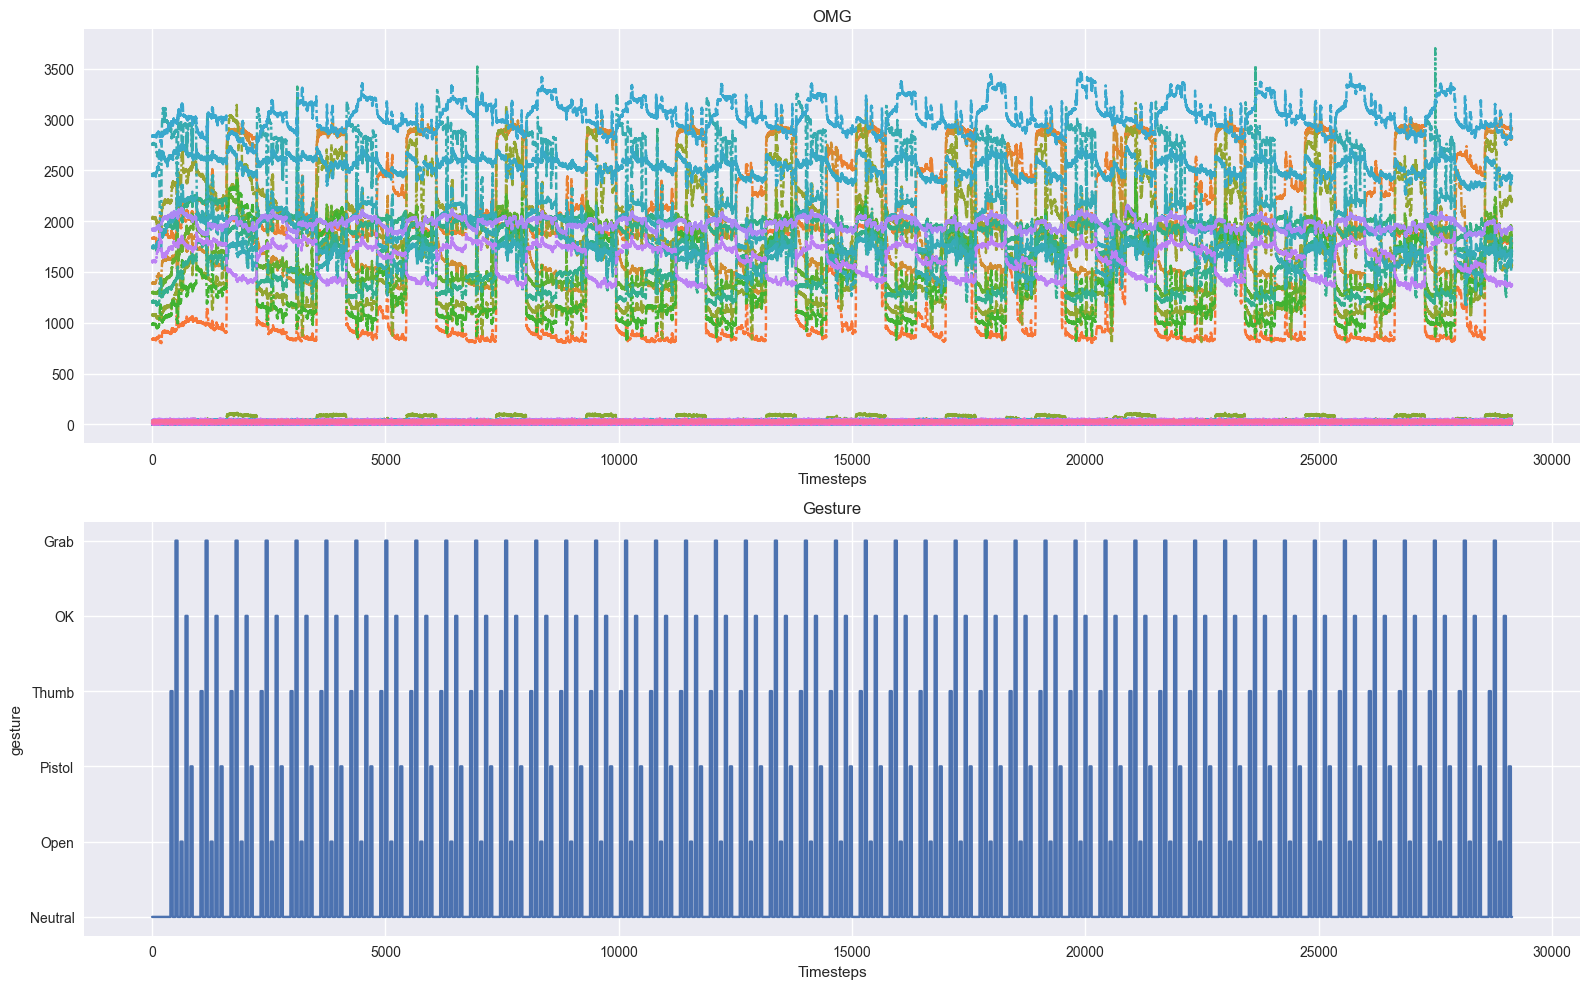

In [83]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1), ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

## Анализ данных

Рассмотрим наши временные ряды более локально, будем просматривать каждые 100 временных шагов.

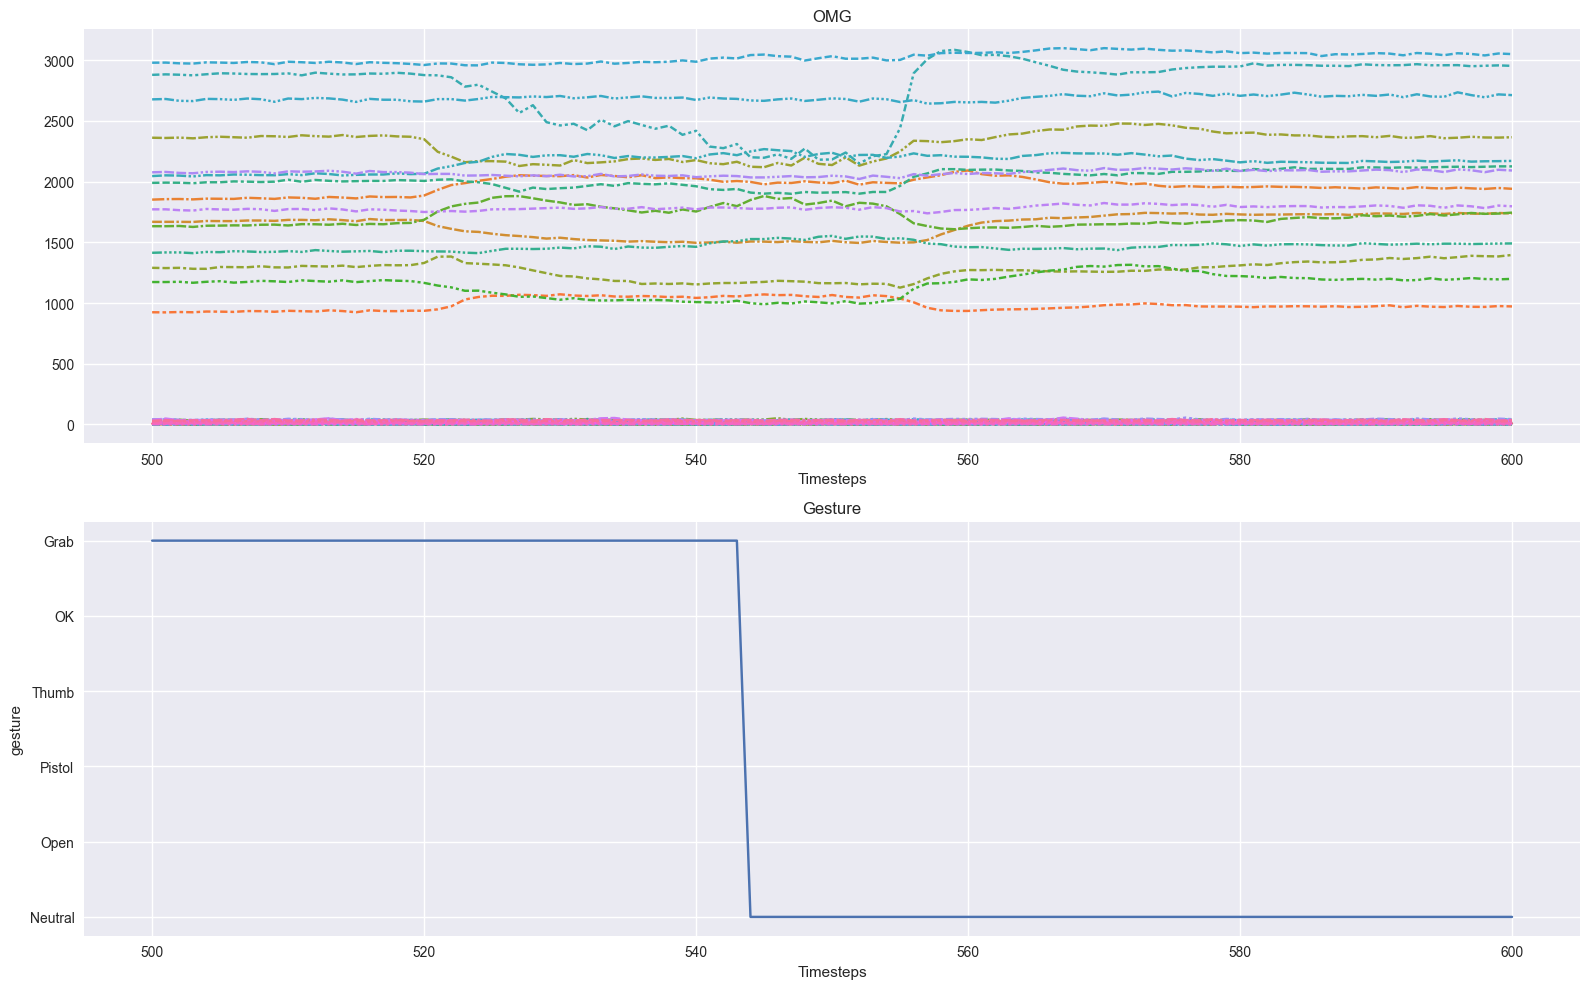

In [84]:
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

### Удаление задержки

Если мы просмотрим несколько таких сэмплов, то сразу станет понятным, что в данных присутствует задержка, от которой необходимо избавиться.

Реализуем следующую идею: воспользуемся шифтером(сместим наши данные) на n количество временных шагов влево, число n подберем таким образом, чтобы взаимная корреляция временного ряда суммы абсолютных значений производных наших признаков с временным рядом выполнения жестов(число 1 - жест выполняется, число 0 - нейтральное положение руки) была максимальна.

n: 18, cor: 0.2602410261445444


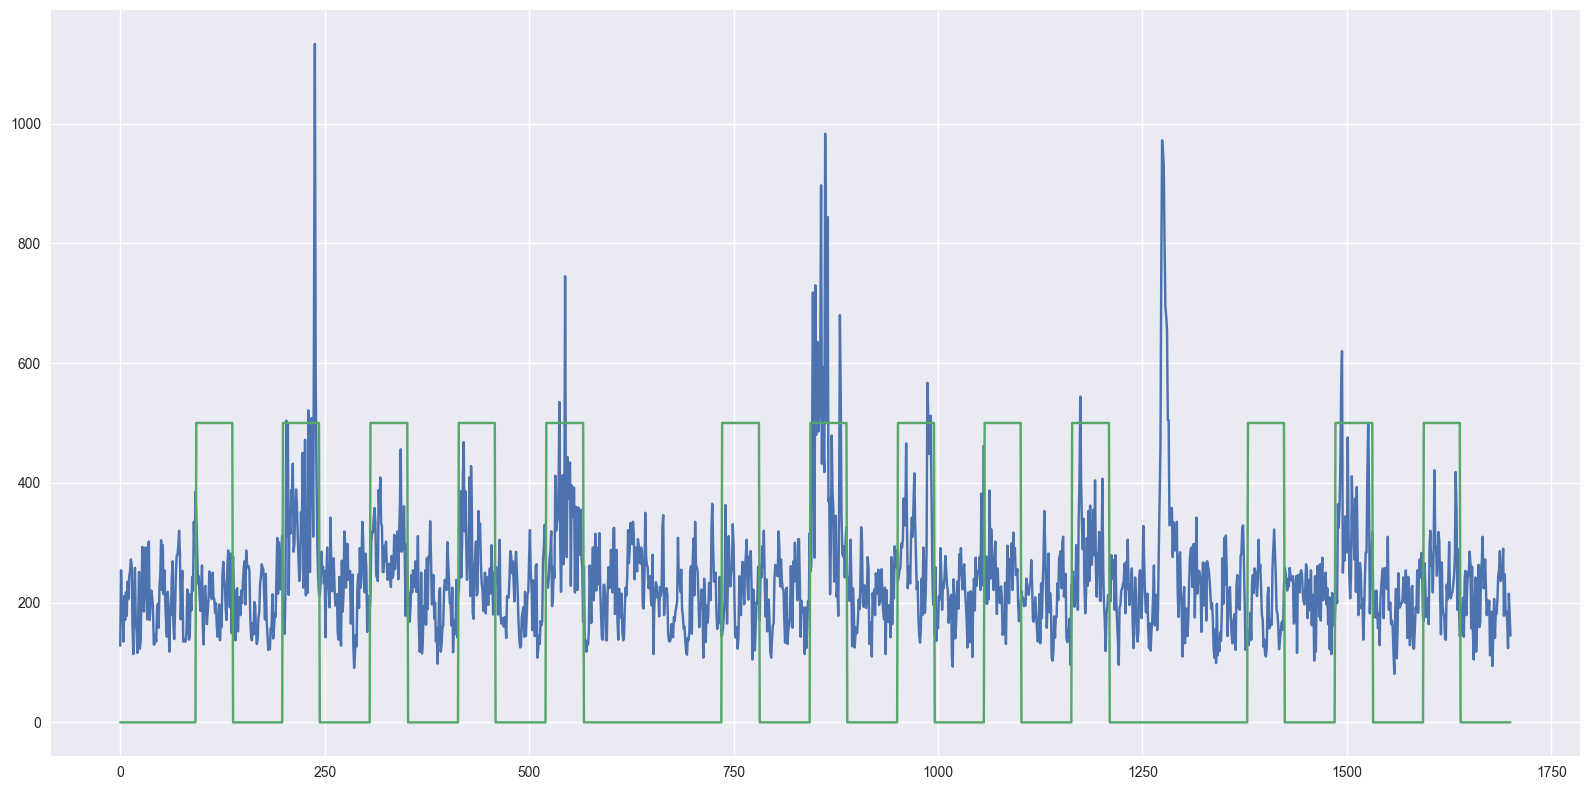

In [85]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result
    
#Применяем полученную функцию
n = get_best_shifter(data, res_plot=True)['n']

#experiment.log_figure(figure=plt)

Теперь к нашим данным применяем функцию data_shifter со значением n равным тому, что получили при использовании get_best_shifter.

In [86]:
#Применяем функцию
data = data_shifter(data, n)
print(f'Data shape: {data.shape}')
data

Data shape: (29127, 51)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,6,4,6,842,1834,1,1384,5,3,4,...,25,18,10,12,1,11,18,34,29,0
1,7,0,6,840,1832,1,1390,4,4,4,...,24,17,9,13,1,9,19,33,27,0
2,25,1,0,837,1828,1,1389,0,5,2,...,27,24,10,23,1,9,24,38,28,0
3,2,4,3,841,1834,0,1392,3,7,4,...,22,20,9,10,1,10,21,37,20,0
4,7,3,1,838,1833,1,1392,0,5,2,...,33,16,4,23,1,6,17,32,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29122,8,2,8,1791,2906,1,2819,12,4,2,...,25,17,11,14,1,11,17,32,26,0
29123,5,1,7,1790,2904,1,2816,14,2,0,...,28,22,8,20,2,12,24,39,32,0
29124,3,4,10,1794,2913,0,2824,17,6,6,...,24,21,10,12,1,10,16,33,28,0
29125,4,9,9,1788,2909,1,2819,14,4,2,...,24,20,10,12,0,11,16,36,27,0


Давайте посмотрим на графики после смещения.

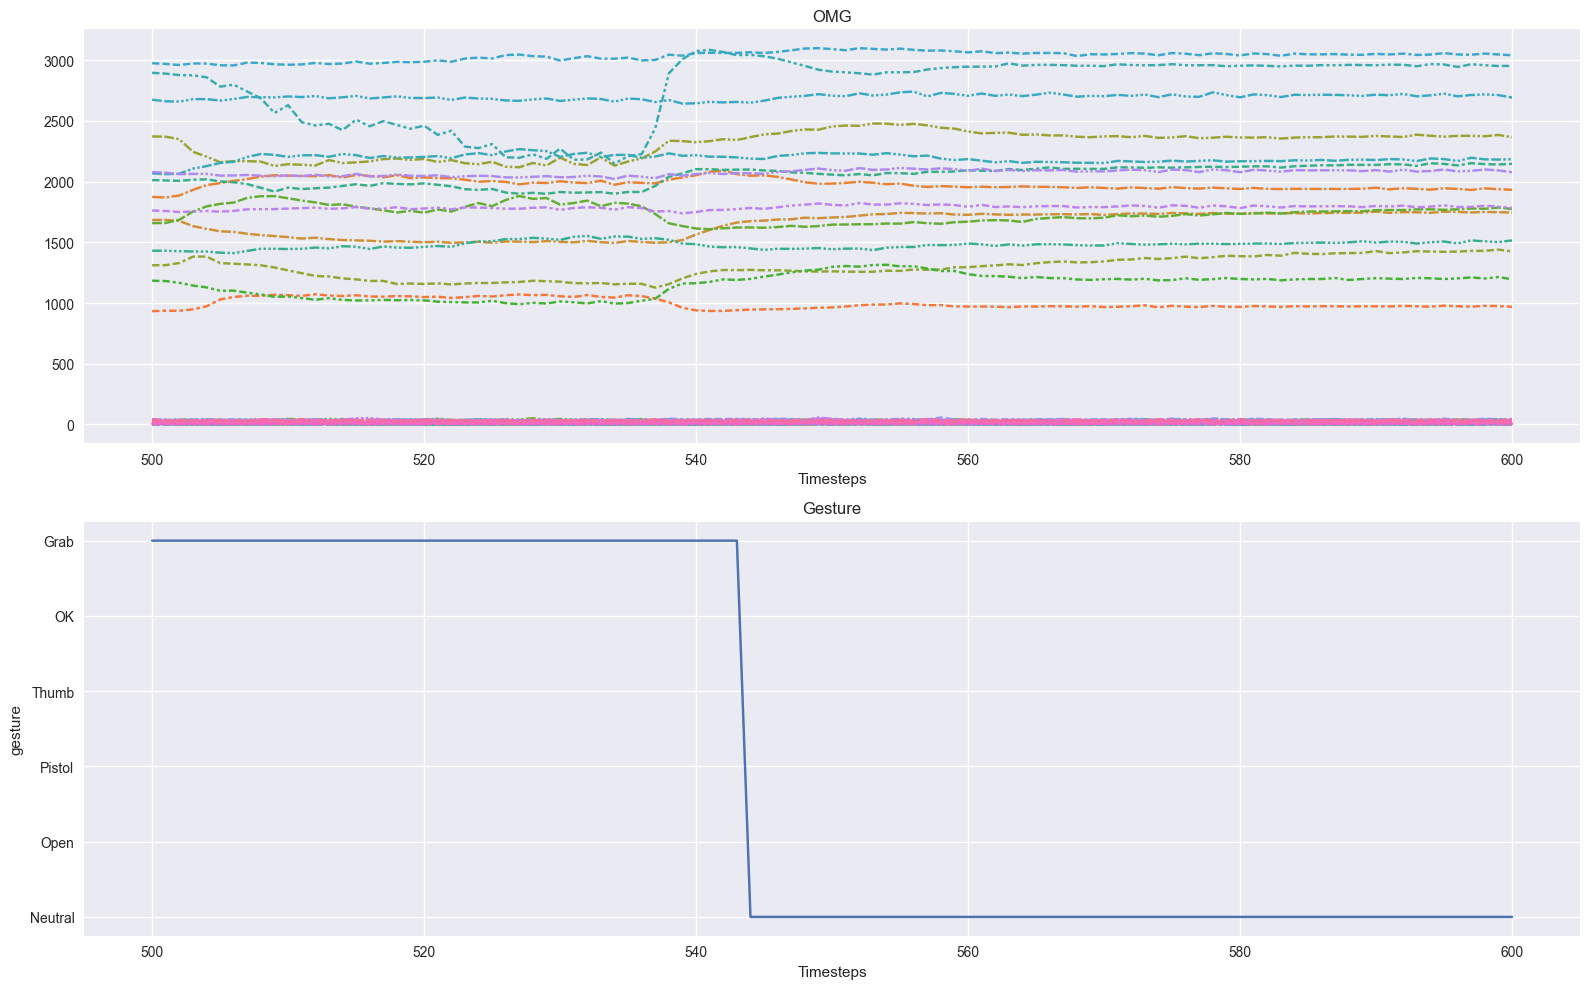

In [87]:
sample_number = 5

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

#experiment.log_figure(figure=plt)

### Сбалансированность классов

Посмотрим на распределение целевой переменной.

Text(0.5, 1.0, 'Баланс классов')

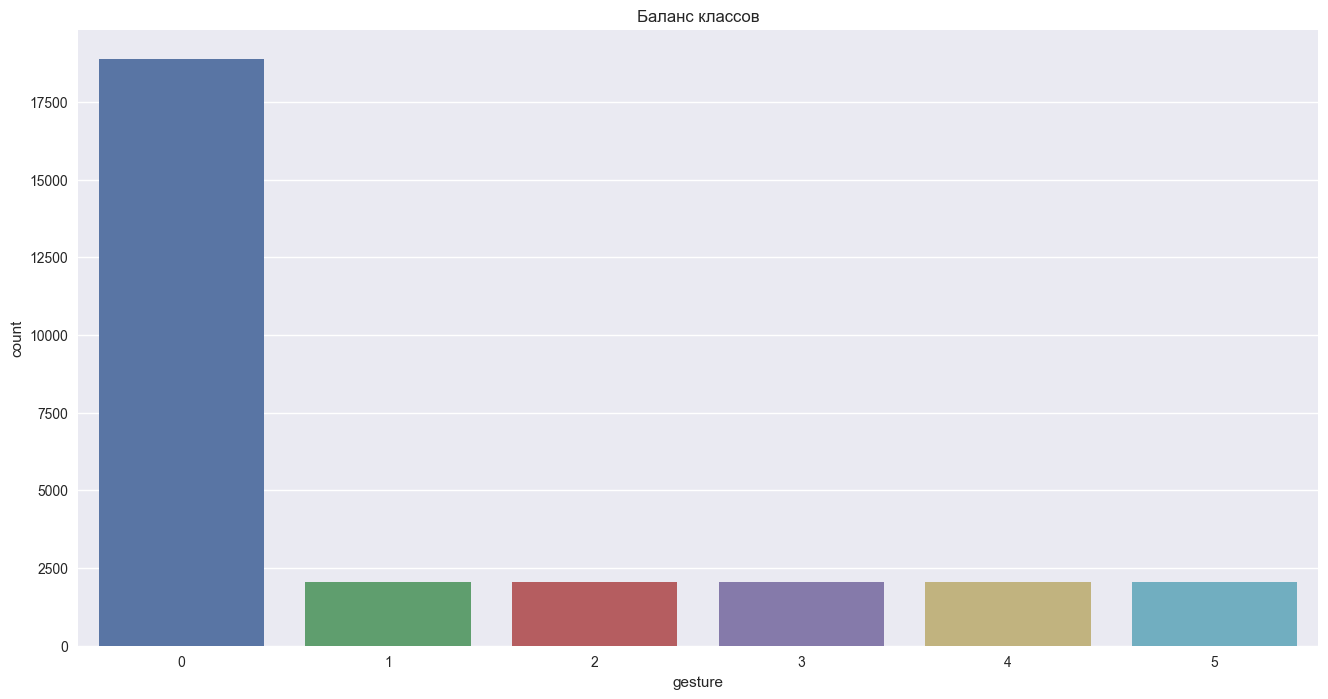

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='gesture', ax=ax)
ax.set_title('Баланс классов')

Видим, что классы несбалансированны. Перед подачей данных в модель данный нужно будет стандартизировать. Если мы используем рекурентную сеть, то в данном случае это обязательно, чтобы упростить последующее умножение входной матрицы.

## Предобработка данных. Feature engineering.


Давайте сгенерируем признаки из нашего датасета с различными таймстепами:

1. Производные для каждого признака и сумму производных.
2. Тренды (не изменяется - 0, убывает - 1, возрастает - 2).
3. Средние значения по показаниям с датчиков.

In [89]:
def get_trend(derivative):
    #Получает тренд из производной
    if derivative > 0:
        return 2
    elif derivative < 0:
        return 1
    else:
        return 0

def create_features(data, n_diff, sum_create=False, trend_create=False, mean_create=False):
    """Изначально создает признаки производных для наших данных, также можно добавить тренды, среднии значения.

    Args:
        data: Наши данные
        n_diff (_type_): Кол-во таймстепов для разницы
        sum_create (bool, optional): Если True, то добавит признак суммы производных. Defaults to False.
        trend_create (bool, optional): Если True, то добавит признаки трендов. Defaults to False.
        mean_create (bool, optional): Если True, то добавит признаки средних. Defaults to False.


    Returns:
        data: Данные со сгенерированными признаками
    """
    #Имена признаков
    col_names = [str(x) for x in range(50)]
    #Для каждого признака добавляем признак производных
    for col in col_names:
        data[f'{col}_diff_{n_diff}'] = data[col].diff(n_diff).fillna(0)
        if trend_create:
            data[f'{col}_trend_{n_diff}'] = data[f'{col}_diff_{n_diff}'].apply(get_trend)
        if mean_create:
            data[f'mean_{n_diff}'] = data.drop('gesture', axis=1).shift(n_diff).mean(axis=1).fillna(0)
        
        
    #Если надо, то добавляем сумму производных 
    if sum_create:
        data[f'sum_diff_{n_diff}'] = data[[f'{col}_diff_{n_diff}' for col in col_names]].sum(axis=1)
    #Возвращаем наши данные
    return data

def get_features(data, n_diff, count, sum_create=False, trend_create=False, mean_create=False):
    #Добавляет признаки к нашим данным от n_diff до n_diff * count отступов
    for i in range(1, count + 1):
        data = create_features(data, n_diff * i, sum_create=sum_create, trend_create=trend_create, mean_create=mean_create)
    #Возвращаем данные со сгенерированными признаками    
    return data
        
data = get_features(data, 5, 3, sum_create=True, trend_create=True, mean_create=True)
print(f'Data shape: {data.shape}')
print(f'Итоговые столбцы:\n {data.columns.tolist()}')
data.head()

Data shape: (29127, 357)
Итоговые столбцы:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'gesture', '0_diff_5', '0_trend_5', 'mean_5', '1_diff_5', '1_trend_5', '2_diff_5', '2_trend_5', '3_diff_5', '3_trend_5', '4_diff_5', '4_trend_5', '5_diff_5', '5_trend_5', '6_diff_5', '6_trend_5', '7_diff_5', '7_trend_5', '8_diff_5', '8_trend_5', '9_diff_5', '9_trend_5', '10_diff_5', '10_trend_5', '11_diff_5', '11_trend_5', '12_diff_5', '12_trend_5', '13_diff_5', '13_trend_5', '14_diff_5', '14_trend_5', '15_diff_5', '15_trend_5', '16_diff_5', '16_trend_5', '17_diff_5', '17_trend_5', '18_diff_5', '18_trend_5', '19_diff_5', '19_trend_5', '20_diff_5', '20_trend_5', '21_diff_5', '21_trend_5', '22_diff_5', '22_trend_5', '23_diff_5', '23_trend_5', '24_diff_5', '24

,0,1,2,3,4,5,6,7,8,9,...,45_trend_15,46_diff_15,46_trend_15,47_diff_15,47_trend_15,48_diff_15,48_trend_15,49_diff_15,49_trend_15,sum_diff_15
0,6,4,6,842,1834,1,1384,5,3,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,7,0,6,840,1832,1,1390,4,4,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,25,1,0,837,1828,1,1389,0,5,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,2,4,3,841,1834,0,1392,3,7,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,7,3,1,838,1833,1,1392,0,5,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Подготовим данные для подачи в рекуретную сеть с GRU слоем.
Для этого нам нужно установить количество временных шагов (лаг) и поделить данные на тренировочную и тестовую выборки.
Так как количество временных шагов должно быть достаточным, чтобы в них попадали показания датчиков обязательно на нейтральном положении руки и при выполнении жеста.

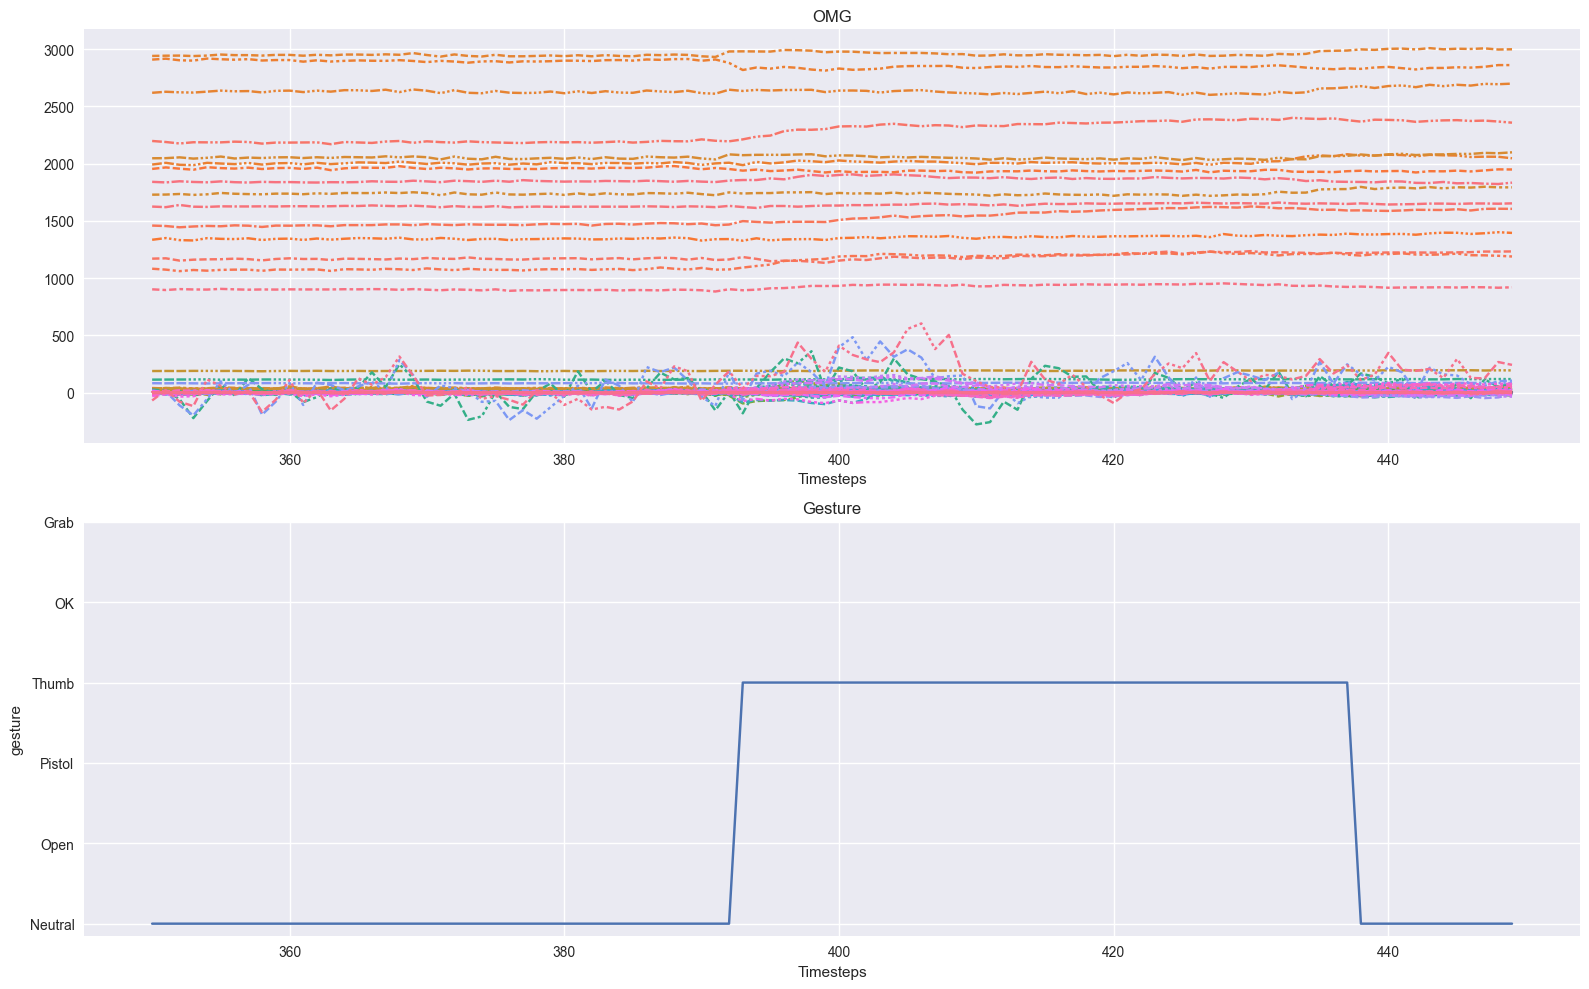

In [90]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data.drop('gesture', axis=1).iloc[350:450], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data['gesture'].iloc[350:450], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

In [91]:
#зафиксируем переменные - кол-во временных шагов в одном лаге и кол-во классов(методом подбора 40 наиболее оптимально), рассчитаем количество образцов в данных
time_steps = 40 
num_classes = 6

In [92]:
#записываем в переменную остаток от деления длины датасета на кол-во временных шагов
remainder = len(data)%time_steps
#отрезаем от данных первые строки (time steps) по количеству остатка, чтобы длина данных была кратна временному лагу
#отрезаем от начала данных, потому что, как правило, сначала идет задержка или нейтральное состояние датчиков
data = data[remainder:]
print(data.shape)

(29120, 357)


In [93]:
num_samples = data.shape[0] // time_steps
print(num_samples)

728


In [94]:
#разобьем данные на тренировочную и тестовые выборки, кратные временному лагу, в пропорции 0.8/0.2
X = data.drop('gesture', axis=1)
y = data['gesture']

test_start_index = (round(num_samples* 0.8)*time_steps)

In [95]:
X_train = X.iloc[:test_start_index]
X_test = X.iloc[test_start_index:].reset_index(drop=True)
y_train = y.iloc[:test_start_index]
y_test = y.iloc[test_start_index:]

assert data.shape[0] == X_train.shape[0] + X_test.shape[0]

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (23280, 356)
Test shape: (5840, 356)


## Отбор признаков

Реализуем отбор признаков.

In [96]:
selector = SelectKBest(f_classif, k=40)
selector.fit(X_train, y_train)

selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_test.shape}')

#log_model(experiment, model=selector, model_name='Feature Selector')

Отобранные признаки: ['12' '16' '22' '27' '28' '30' '31' '32' '37' '38' '30_diff_5' 'mean_10'
 '21_trend_10' '22_trend_10' '30_diff_10' '30_trend_10' '38_diff_10'
 '39_trend_10' '3_trend_15' '4_diff_15' '4_trend_15' '6_trend_15'
 '12_trend_15' '13_diff_15' '16_diff_15' '16_trend_15' '17_diff_15'
 '17_trend_15' '21_trend_15' '22_diff_15' '22_trend_15' '28_diff_15'
 '30_diff_15' '30_trend_15' '31_diff_15' '38_diff_15' '38_trend_15'
 '39_diff_15' '39_trend_15' 'sum_diff_15']
Train Data shape: (23280, 40)
Test Data shape: (5840, 40)


In [97]:
#стандартизируем данные с помощью StandardScaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled= scaler.transform(X_test)

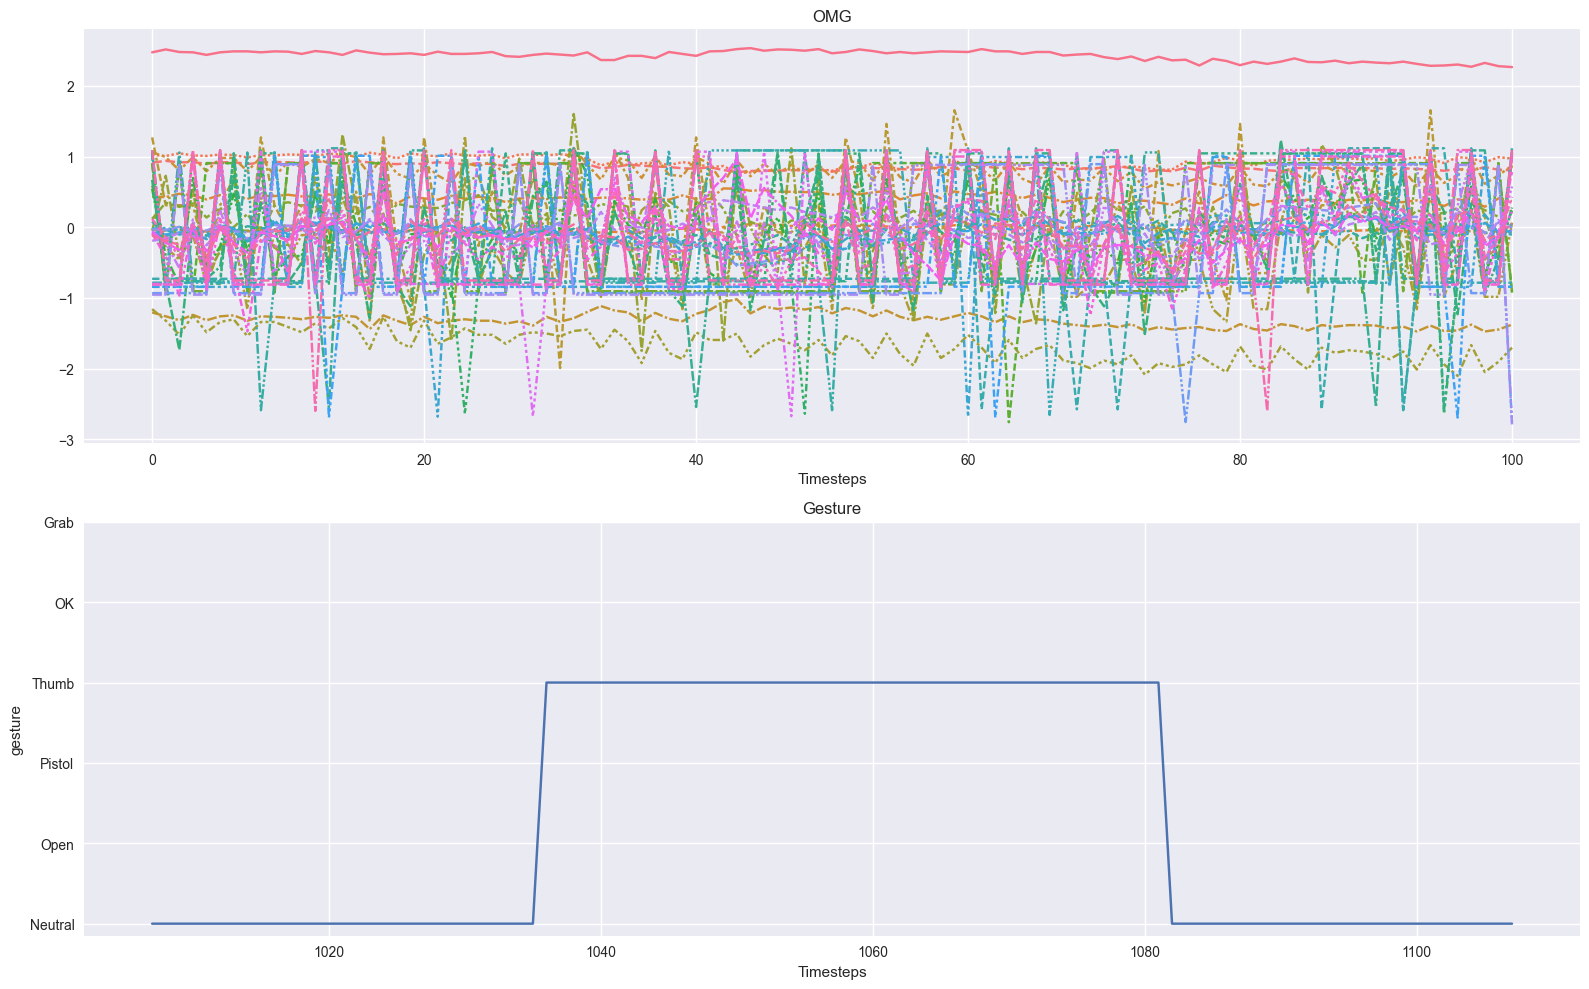

In [98]:
#посмотрим на данные после преобразований
sample_number = 10

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(X_train_scaled[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(y_train[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

Видны уже более явные изменения в показаниях датчиков даже для труднопредсказываемого жеста Thumb.

## Рекурентная сеть со слоем GRU

### Подготовим данные для подачи в модель 

In [99]:
print(f'Train shape: {X_train_scaled.shape}')
print(f'Test shape: {X_test_scaled.shape}')

Train shape: (23280, 40)
Test shape: (5840, 40)


Делим данные по количеству временных шагов.

In [100]:
X_train_gru = X_train_scaled.reshape(X_train.shape[0]//time_steps,time_steps,40)
X_test_gru = X_test_scaled.reshape(X_test.shape[0]//time_steps,time_steps,40)

In [31]:
print(X_train_gru.shape)
print(X_test_gru.shape)

(390, 40, 40)
(98, 40, 40)


In [101]:
# Преобразуем целевую переменную в one-hot encoding
num_classes = 6 # Количество классов жестов
y_train_cat= to_categorical(y_train, num_classes=num_classes)
y_test_cat=to_categorical(y_test,num_classes=num_classes)
y_test_cat

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [102]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(23280, 6)
(5840, 6)


In [103]:
#целевую переменную также делим на лаги 
y_train_gru = y_train_cat.reshape(y_train_cat.shape[0]//time_steps,time_steps,num_classes)
y_test_gru = y_test_cat.reshape(y_test_cat.shape[0]//time_steps,time_steps,num_classes)

print(X_train_gru.shape)
print(X_test_gru.shape)
print(y_train_gru.shape)
print(y_test_gru.shape)

(582, 40, 40)
(146, 40, 40)
(582, 40, 6)
(146, 40, 6)


In [104]:
# Создаем модель

model = Sequential()
model.add(GRU(100, input_shape=(time_steps, 40), return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 40, 100)        │        42,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 6)          │           606 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,306 (208.23 KB)

 Trainable params: 53,306 (208.23 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Обучаем модель
model.fit(X_train_gru, y_train_gru, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6046 - loss: 1.4386 - val_accuracy: 0.6466 - val_loss: 1.0929
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6663 - loss: 1.0444 - val_accuracy: 0.7028 - val_loss: 0.9419
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7365 - loss: 0.8755 - val_accuracy: 0.7387 - val_loss: 0.8274
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7835 - loss: 0.7369 - val_accuracy: 0.7656 - val_loss: 0.7236
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7952 - loss: 0.6516 - val_accuracy: 0.7868 - val_loss: 0.6471
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8242 - loss: 0.5603 - val_accuracy: 0.7998 - val_loss: 0.5911
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8393 - loss: 0.5089 - val_accuracy: 0.8165 - val_loss: 0.5398
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8570 - loss: 0.4527 - val_accuracy: 0.8233 - v

In [106]:
predictions_train = model.predict(X_train_gru)
predictions_test = model.predict(X_test_gru)
print(predictions_train.shape)
print(predictions_test.shape)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(582, 40, 6)
(146, 40, 6)


In [107]:
y_train_proba=np.reshape(predictions_train,(predictions_train.shape[0]*time_steps,6))
y_test_proba = np.reshape(predictions_test,(predictions_test.shape[0]*time_steps,6))

print(y_train_proba.shape)
print(y_test_proba.shape)

(23280, 6)
(5840, 6)


Так как модель возвращает массив со значениями вероятностей классов, то перекодируем результат в классы.

In [108]:
y_pred_train=np.argmax(y_train_proba,axis=1)
print(y_pred_train.shape)

y_pred_test = np.argmax(y_test_proba,axis=1)
print(y_pred_test.shape)

(23280,)
(5840,)


In [109]:
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     15133
           1       0.95      0.91      0.93      1638
           2       0.93      0.82      0.87      1590
           3       0.84      0.69      0.76      1639
           4       0.96      0.86      0.91      1644
           5       0.92      0.90      0.91      1636

    accuracy                           0.93     23280
   macro avg       0.92      0.86      0.89     23280
weighted avg       0.92      0.93      0.92     23280



In [110]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3740
           1       0.77      0.82      0.79       413
           2       0.69      0.57      0.62       456
           3       0.74      0.48      0.58       410
           4       0.84      0.63      0.72       410
           5       0.82      0.74      0.78       411

    accuracy                           0.85      5840
   macro avg       0.79      0.70      0.74      5840
weighted avg       0.84      0.85      0.84      5840



In [111]:
f1_avg_table = {
    'pilot': ["2023-05-07_15-19-05", "2023-05-07_16-54-27", "2023-05-12_19-17-00", 
              "2023-05-15_16-16-08", "2023-05-15_17-12-24", "2023-05-31_17-14-41"],
    'train': [0.89, 0.88, 0.88, 0.89, 0.77, 0.94],
    'test': [0.88, 0.74, 0.84, 0.76, 0.65, 0.89],
    'Thumb': [0.70, 0.69, 0.88, 0.57, 0.39, 0.78],
    'Ok': [0.82, 0.79, 0.79, 0.75, 0.75, 0.85]
}

f1_avg_table = pd.DataFrame(f1_avg_table)
mean_values = f1_avg_table[['train', 'test', 'Thumb', 'Ok']].mean().round(2)

mean_row = pd.DataFrame([['average'] + mean_values.tolist()], columns=f1_avg_table.columns)
f1_avg_table = pd.concat([f1_avg_table, mean_row], ignore_index=True)

print(f1_avg_table)

                 pilot  train  test  Thumb    Ok
0  2023-05-07_15-19-05   0.89  0.88   0.70  0.82
1  2023-05-07_16-54-27   0.88  0.74   0.69  0.79
2  2023-05-12_19-17-00   0.88  0.84   0.88  0.79
3  2023-05-15_16-16-08   0.89  0.76   0.57  0.75
4  2023-05-15_17-12-24   0.77  0.65   0.39  0.75
5  2023-05-31_17-14-41   0.94  0.89   0.78  0.85
6              average   0.88  0.79   0.67  0.79


## Ниже результаты использования других моделей:

## Подготовка данных к подаче в модель

### Train/Test
Перейдем к подготовке наших данных. Для начала разделяем выборку на тестовую, валидационную и тренировочную, размер разделений 0.2/0.2/0.6.

In [19]:
X = data.drop('gesture', axis=1)
y = data['gesture']

test_start_index = round(data.shape[0] * 0.8)

X_train = X.iloc[:test_start_index]
X_test = X.iloc[test_start_index:].reset_index(drop=True)
y_train = y.iloc[:test_start_index]
y_test = y.iloc[test_start_index:]

assert data.shape[0] == X_train.shape[0] + X_test.shape[0]

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (15640, 356)
Test shape: (3910, 356)


## Стандартизация данных

Так как при сборе данных статистические характеристики наших временных рядов зависят от внешних факторов и пилота, с которого собираются данные, то для каждого временного ряда одни и те же признаки будут иметь разный масштаб, среднее и т.д.

Поэтому был реализован OnlineStandartScaler, который производит онлайн стандартизацию, изменяя статистики с каждым новым объектом.
Применим его для обучающей и отдельно для тестовой выборки.

In [19]:
#Стандартизируем обучающую выборку
train_scaler = OnlineStandartScaler()
for idx, row in X_train.iterrows():
   row_scaled = train_scaler.fit_transform(row)
   X_train.loc[idx, :] = row_scaled
#Стандартизируем тренировочную выборку
test_scaler = OnlineStandartScaler()
for idx, row in X_test.iterrows():
   row_scaled = test_scaler.fit_transform(row)
   X_test.loc[idx, :] = row_scaled

## Построение модели

Начнем с решающего дерева. Подбор гиперпараметров реализуем с помощью GridSearchCV.

In [21]:
#Модель
dt_model = DecisionTreeClassifier(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
    'criterion': ['gini', 'entropy']
}
#Валидатор
tscv = TimeSeriesSplit(n_splits=3) 
#Подбор гиперпараметров
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train, y_train)
print(f'best params: {grid_dt.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_dt.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_dt.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

dt_metrics = {'f1_mean': metrics.f1_score(y_test, y_test_predict, average=None).mean()}
experiment.log_parameters(grid_dt.best_params_)
experiment.log_metrics(dt_metrics)
log_model(experiment, model=grid_dt.best_estimator_, model_name='Decision Tree Classifier')

best params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 9}
Train classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     10151
           1       0.89      0.90      0.90      1104
           2       0.89      0.80      0.84      1059
           3       0.84      0.55      0.66      1104
           4       0.89      0.73      0.80      1104
           5       0.98      0.96      0.97      1118

    accuracy                           0.90     15640
   macro avg       0.90      0.82      0.85     15640
weighted avg       0.90      0.90      0.90     15640

Mean-f1 train:  0.8514168743753285
Test classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      2490
           1       0.55      0.72      0.62       276
           2       0.66      0.56      0.60       315
           3       0.60      0.40      0.48       276
           4  

Попробуем модель случайного леса

In [22]:
#Модель
rf_model = RandomForestClassifier(max_depth=11, min_samples_leaf=9, criterion='entropy', random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train, y_train)
print(f'best params: {grid_rf.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_rf.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_rf.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

rf_metrics = {'f1_mean': metrics.f1_score(y_test, y_test_predict, average=None).mean()}
experiment.log_parameters(grid_rf.best_params_)
experiment.log_metrics(rf_metrics)
log_model(experiment, model=grid_rf.best_estimator_, model_name='Random Forest Classifier')

best params: {'n_estimators': 180}
Train classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     10151
           1       0.98      0.91      0.95      1104
           2       0.99      0.81      0.89      1059
           3       0.98      0.51      0.67      1104
           4       0.98      0.76      0.86      1104
           5       0.99      0.97      0.98      1118

    accuracy                           0.92     15640
   macro avg       0.97      0.82      0.88     15640
weighted avg       0.93      0.92      0.92     15640

Mean-f1 train:  0.8805959421023349
Test classification report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2490
           1       0.93      0.81      0.86       276
           2       0.91      0.48      0.63       315
           3       0.90      0.23      0.37       276
           4       0.90      0.68      0.78       276
   

Модели бустингов из xgboost и catboost.

In [23]:
#Обучаем модель
gb_model = xgboost.XGBClassifier(random_state=random_seed)
gb_model.fit(X_train, y_train)
#Делаем предсказания на тренировочном наборе данных
y_train_predict = gb_model.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = gb_model.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10151
           1       1.00      1.00      1.00      1104
           2       1.00      1.00      1.00      1059
           3       1.00      1.00      1.00      1104
           4       1.00      1.00      1.00      1104
           5       1.00      1.00      1.00      1118

    accuracy                           1.00     15640
   macro avg       1.00      1.00      1.00     15640
weighted avg       1.00      1.00      1.00     15640

Mean-f1 train:  1.0
Test classification report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2490
           1       0.89      0.87      0.88       276
           2       0.90      0.71      0.80       315
           3       0.87      0.37      0.52       276
           4       0.91      0.80      0.86       276
           5       0.92      0.88      0.90       277

In [24]:
#Обучаем модель
cat_model = catboost.CatBoostClassifier(random_state=random_seed)
cat_model.fit(X_train, y_train)
#Делаем предсказания на тренировочном наборе данных
y_train_predict = cat_model.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = cat_model.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

Learning rate set to 0.091039
0:	learn: 1.5728949	total: 166ms	remaining: 2m 45s
1:	learn: 1.4273270	total: 180ms	remaining: 1m 29s
2:	learn: 1.3112033	total: 195ms	remaining: 1m 4s
3:	learn: 1.2179293	total: 210ms	remaining: 52.3s
4:	learn: 1.1378297	total: 227ms	remaining: 45.2s
5:	learn: 1.0734303	total: 243ms	remaining: 40.3s
6:	learn: 1.0189435	total: 260ms	remaining: 36.8s
7:	learn: 0.9671624	total: 275ms	remaining: 34.1s
8:	learn: 0.9226290	total: 290ms	remaining: 32s
9:	learn: 0.8881836	total: 307ms	remaining: 30.4s
10:	learn: 0.8523923	total: 323ms	remaining: 29.1s
11:	learn: 0.8252394	total: 340ms	remaining: 28s
12:	learn: 0.8015140	total: 356ms	remaining: 27.1s
13:	learn: 0.7752753	total: 373ms	remaining: 26.3s
14:	learn: 0.7519927	total: 391ms	remaining: 25.7s
15:	learn: 0.7303218	total: 409ms	remaining: 25.2s
16:	learn: 0.7096672	total: 426ms	remaining: 24.6s
17:	learn: 0.6920762	total: 442ms	remaining: 24.1s
18:	learn: 0.6731402	total: 459ms	remaining: 23.7s
19:	learn: 0.

## Улучшение предсказания сгиба большого пальца

Можно заметить, что модели плохо предсказывают сгиб большого пальца, дело в том, что он плохо отличим от нейтрального положения. Давайте обучим две модели последовательно, первая будет делать предсказания на всех данных, а вторая модель на тех данных, которые были предсказаны первой моделью как классы 0 и 3, чтобы улучшить предсказания для плохо отличимого жеста.

За первую модель возьмем ту, что показала лучшие метрики на тесте - случайный лес.

In [25]:
first_model = grid_rf.best_estimator_
first_model_train_pred = first_model.predict(X_train)
first_model_test_pred = first_model.predict(X_test)

Формируем данные для обучения второй модели и обучаем ее, воспользуемся также случайным лесом.

In [26]:
#Обучающая выборка
X_train_for_second_model = X_train[(first_model_train_pred == 0) | (first_model_train_pred == 3)]
y_train_for_second_model = y_train[(first_model_train_pred == 0) | (first_model_train_pred == 3)].apply(lambda x: 3 if x == 3 else 0)
#Тренировочная выборка
X_test_for_second_model = X_test[(first_model_test_pred == 0) | (first_model_test_pred == 3)]
y_test_for_second_model = y_test[(first_model_test_pred == 0) | (first_model_test_pred == 3)].apply(lambda x: 3 if x == 3 else 0)
#Индексы элементов в исходной выборке
X_train_indexes = X_train_for_second_model.index
X_test_indexes = X_test_for_second_model.index

#Модель
rf_model = RandomForestClassifier(max_depth=11, min_samples_leaf=9, criterion='entropy', random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
seconf_grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
seconf_grid_rf.fit(X_train_for_second_model, y_train_for_second_model)
second_model = seconf_grid_rf.best_estimator_ 
#Делаем предсказания
second_model_train_pred = second_model.predict(X_train_for_second_model)
second_model_test_pred = second_model.predict(X_test_for_second_model)
#Собираем итоговые предсказания двух моделей
#Тренировочные
total_train_pred = first_model_train_pred
total_train_pred[X_train_indexes] = second_model_train_pred
print(f'Train classification report:\n {metrics.classification_report(y_train, total_train_pred)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, total_train_pred, average=None).mean()}')
#Тестовые
total_test_pred = first_model_test_pred
total_test_pred[X_test_indexes] = second_model_test_pred
print(f'Test classification report:\n {metrics.classification_report(y_test, total_test_pred)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, total_test_pred, average=None).mean()}')

Train classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     10151
           1       0.98      0.91      0.95      1104
           2       0.99      0.81      0.89      1059
           3       0.99      0.68      0.81      1104
           4       0.98      0.76      0.86      1104
           5       0.99      0.97      0.98      1118

    accuracy                           0.94     15640
   macro avg       0.97      0.85      0.91     15640
weighted avg       0.94      0.94      0.93     15640

Mean-f1 train:  0.9051642833399081
Test classification report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      2490
           1       0.93      0.81      0.86       276
           2       0.91      0.48      0.63       315
           3       0.91      0.27      0.41       276
           4       0.90      0.68      0.78       276
           5       0.91      0.90     

In [27]:
#experiment.end()

COMET ERROR: Heartbeat processing error
